In [1]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torchvision
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

<div dir=rtl>

در ابتدا با مراجعه به این [لینک](https://towardsdatascience.com/downloading-kaggle-datasets-directly-into-google-colab-c8f0f407d73a) داده مدنظر را از kaggle دریافت و در گوگل کولب بارگذاری می کنیم. با mount کردن درایو می توانیم از داده دانلود و از زیپ خارج شده در کولب استفاده کنیم.


</div>

In [2]:
# Loading data
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Import OS for navigation and environment set up
import os
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/ML/Pytorch/kaggle'

In [ ]:
!pip install kaggle
# kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Navigate into Drive where you want to store your Kaggle data
os.chdir('/content/gdrive/My Drive/ML/Pytorch/kaggle')
# Paste and run the copied API command, the data will download to the current directory
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

100% 2.29G/2.29G [00:31<00:00, 16.8MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.4MB/s]


['kaggle.json', 'chest-xray-pneumonia.zip']

In [ ]:
# Complete path to storage location of the .zip file of data
zip_path = '/content/gdrive/My Drive/ML/Pytorch/kaggle/chest-xray-pneumonia.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly 
!unzip -q 'chest-xray-pneumonia.zip'
# View the unzipped contents in the virtual machine
os.listdir()

['.config', 'chest-xray-pneumonia.zip', 'chest_xray', 'gdrive', 'sample_data']

In [3]:
main_dir = '/content/gdrive/My Drive/ML/Pytorch/kaggle/chest_xray'
train_dir = main_dir + '/train'
# train_data = torchvision.datasets.ImageFolder(train_dir, transform=T.Compose([T.Resize((150,150)), T.ToTensor()]))

test_dir = main_dir + '/test'
# test_data = torchvision.datasets.ImageFolder(test_dir, transform=T.Compose([T.Resize((150,150)), T.ToTensor()]))

val_dir = main_dir + '/val'
# val_data = torchvision.datasets.ImageFolder(val_dir, transform=T.Compose([T.Resize((150,150)), T.ToTensor()]))

In [5]:
num_workers = 4
batch_size = 128
n_epochs = 20

device = torch.device('cuda:0')
print(device)

cuda:0


<div dir=rtl align=justify>


*   باید Dataset مدنظر را طراحی کنیم. جهت ساخت custom dataset مدنظر توابعی رو به رو را override می کنیم __init__ ، __getitem__ ,__len__. در دیتاست مدنظر از قابلیت های ImageFolder در پایتورچ استفاده می کنیم تا با استفاده از پوشه های تعبیه شده در پوشه حاوی دیتاست، داده مربوط به آموزش، ولیدیشن و تست را ذخیره کنیم
*   پس از این مرحله Dataloder را می سازیم تا batch های مدنظر را طراحی کنیم. batch را 128، تعداد worker هارا 4 و shuffle را true قرار می دهیم. با توجه به خواسته ی سوال از data augmentation در دیتا ست طراحی شده استفاده شده است. در 50% مواقع این transformation صورت می گیرد و در هر بار به احتمال 70% هریک از این 3 transformation روی داده اعمال می گردد. Data augmentation استراتژی ای است که این امکان را می دهد تا بدون جمع آوری داده های جدید، به طور قابل توجهی تنوع داده های موجود برای مدل های آموزشی را افزایش دهند. برای آموزش شبکه های عصبی بزرگ معمولاً از تکنیک های افزایش داده مانند cropping, Random Grayscale, horizontal flipping، Color Jitter و … استفاده می شود. با وارد کردن تغییرات تصادفی در تصویر اصلی، تنوع را افزایش می دهد، اما تعداد تصاویر / نمونه های مجموعه داده را افزایش نمی دهد. که در این بین از Resize، horizontal flippint، Grayscale و Color Jitter استفاده شد.

</div>

# Prepare Dataset and DataLoader


**Transforms**

1.   transforms.ColorJitter


> Randomly change the brightness, contrast, saturation and hue of an image. If the image is torch Tensor, it is expected to have […, 3, H, W] shape, where … means an arbitrary number of leading dimensions. If img is PIL Image, mode “1”, “L”, “I”, “F” and modes with transparency (alpha channel) are not supported.


2.   transforms.RandomHorizontalFlip


> Horizontally flip the given image randomly with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions


3.   transforms.RandomGrayscale


> Randomly convert image to grayscale with a probability of p (default 0.1). If the image is torch Tensor, it is expected to have […, 3, H, W] shape, where … means an arbitrary number of leading dimensions





In [6]:
import random

class MyImageDataset(Dataset):
  def __init__(self, root, transform=None, target_transform=None, augment=None):
    self.root = root
    self.augment = augment
    self.transform = transform
    self.target_transform = target_transform
    self.image_folder = torchvision.datasets.ImageFolder(self.root)

  def __len__(self):
    return len(self.image_folder.imgs)

  def __getitem__(self, idx):
    path, target = self.image_folder.imgs[idx]
    img = self.image_folder.loader(path)
    if self.transform is not None:
      img = self.transform(img)
    if self.target_transform is not None:
      target = self.target_transform(target)
    if self.augment is not None:
      r = random.uniform(0,1)
      if r > 0.5:
        r1 = random.uniform(0,1)
        r2 = random.uniform(0,1)
        r3 = random.uniform(0,1)
        if r1 > 0.7:
          img = self.augment[0](img)
        if r2 > 0.7:
          img = self.augment[1](img)
        if r3 > 0.7:
          img = self.augment[2](img)
    return img, target

trans=T.Compose(transforms=[T.Resize((216,216)), T.ToTensor()])
augs=[T.RandomHorizontalFlip(), T.RandomGrayscale(), T.ColorJitter()]
train_ds = MyImageDataset(root=train_dir, transform=trans, augment=augs)
test_ds = MyImageDataset(root=test_dir, transform=trans)
val_ds = MyImageDataset(root=val_dir, transform=trans)

In [7]:
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers = num_workers, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers = num_workers, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers = num_workers, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<div dir=rtl>

پس از این مرحله مدل را طراحی می کنیم. مدل از 2 بخش تشکیل می شود:

*   ابتدا بلاک های مدنظر را طراحی می کنیم که طبق معماری گفته شده دارای دو لایه convolution و بلافاصله بعد آن batch normalization و سپس activation function می باشد. همچنین برای پیاده سازی skip connection از conv استفاده کرده. Conv مربوط به لایه اول و skip دارای stride 3 و دیگر لایه conv دارای stride با مقدار 1 می باشد. با توجه به این اعداد مقدار padding را برای convolution با سایز فیلتر 7 برابر 3، برای فیلتر با سایز 5 برابر 2 و برای فیلتر با سایز 3 برابر 1 قرار داده و convolution مربوط به لایه skip را برابر 1 قرار داده تا با توجه به سایز فیلتر های گفته شده به مشکلی بر نخوریم. در صورتی که میزان stride برابر 1 نباشد یا به به هرشکلی تعداد کانال های خروجی و ورودی برابر نباشد باید از convolution برای تغییر بعد x ورودی استفاده کنیم تا مرحله skip به درستی انجام بگیرد. در این حالت میزان stride همانطور که گفته شد برابر 3 و میزان padding برابر 0 و اندازه فیلتر برابر 1 می باشد. 

*   سپس باید resnet نهایی را پیاده سازی کنیم که از 3 بلوک فوق با سایز فیلتر به ترتیب 7 و5 و3 تشکیل شده است. و در نهایت یک لایه fully connected که در انتها قرار می گیرد.

در ادامه این مراحل نشان داده شده است:


</div>

# Creating Model Class

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=3, kernel_size=7):
      super(Block, self).__init__()

      self.skip = nn.Sequential()
      self.kernel_size = kernel_size
      self.stride = stride

      if stride != 1 or in_channels != out_channels:
        self.skip = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=self.stride, bias=False),
          nn.BatchNorm2d(out_channels))
      else:
        self.skip = None

      self.block = nn.Sequential(
          nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel_size, padding=(self.kernel_size - 1)//2, stride=self.stride, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=self.kernel_size, padding=(self.kernel_size - 1)//2, stride=1, bias=False),
          nn.BatchNorm2d(out_channels))
      self.relu = nn.ReLU()
        
  def forward(self, x):
    identity = x
    out = self.block(x)

    if self.skip is not None:
        identity = self.skip(x)

    out += identity
    out = self.relu(out)

    return out

In [19]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.image_channels = 3
        self.conv1 = nn.Conv2d(self.image_channels, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.layer1 = Block(3, 64, 3, 7)
        self.layer2 = Block(64, 128, 3, 5)
        self.layer3 = Block(128, 256, 3, 3)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256 * 64, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = F.softmax(x, dim=0)

        return x

<div dir=rtl>

* در ادامه باید مراحل آموزش طی بشود. این روند طی 25 ایپاک و iteration های تعریف شده طبق سایز batch ها انجام می گیرد. 

* برای اینکار از Adam optimizer استفاده می کنیم. Lr در ابتدا 0.005 می باشد و در هر 5 ایپاک با استفاده از scheduler پایتورچ این مقدار کاهش پیدا می کند. زمانی که lr در ابتدا ثابت بود میزان train loss روی 0.2 به طور متوسط ثابت می ماند و تغییری شاهد نبودیم بنابراین از روش کاهش lr در هر 5 ایپاک استفاده کردیم و باعث شد میزان loss تا 0.007 به طور متوسط کاهش پیدا کند. 

* در هر 5 ایپاک میزان validation loss نیز روی داده های validation تست می شد. و نتایج آن نیز در ادامه مشاهده می شود.

* در ابتدا drop out در نظر گرفته نمی شد و باعث شد میزان accuracy برای داده های تست 65% باشد درحالیکه برای داده آموزش تقریبا overfit میشد. بنابراین طبق مقالات ارائه شده در ارتباط با نقطه ای که از dropout استفاده میشود، در CONV->RELU->DROP از آن استفاده کرده و احتمال آن را طبق خواسته ی سوال 0.4 در نظر گرفته شد. در این حالت دقت روی داده ی تست تا حدود 75% افزایش پیدا کرد. 

</div>

# Instantiating Model, Optimizer and Loss

In [20]:
import torch.optim as optim

model = ResNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.01)
optimizer = optim.Adam(params=model.parameters(), lr=0.005)
# decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model

In [21]:
val_loss_min = np.Inf
Train_loss = []
Val_loss = []

for epoch in range(25):
  train_loss = 0
  model.train()
    
  for iteration, (data, label) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data.to(device))
    loss = criterion(output, label.to(device))
    loss.backward()
    optimizer.step()

    # update running train loss 
    train_loss += loss.item() * data.shape[0]

  # calculate average trainnig loss over an epoch
  train_loss = train_loss / len(train_loader.sampler)
  Train_loss.append(train_loss)

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

  if (epoch+1) % 5 == 0:
      is_training = model.training
      val_loss = 0
      model.eval()  # preparing model for evaluation
      for data, label in val_loader:
        output = model(data.to(device))
        loss = criterion(output, label.to(device))
        # update running validation loss 
        val_loss += loss.item() * data.shape[0]

      val_loss = val_loss / len(val_loader.sampler)
      Val_loss.append(val_loss)

      if val_loss <= val_loss_min:
        print('\tValidation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(val_loss_min, val_loss))
        val_loss_min = val_loss

      model.train(mode=is_training)

  my_lr_scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 1.255343
Epoch: 2 	Training Loss: 0.292157
Epoch: 3 	Training Loss: 0.214546
Epoch: 4 	Training Loss: 0.154673
Epoch: 5 	Training Loss: 0.185218
	Validation loss decreased (inf --> 1.745737). Saving model ...
Epoch: 6 	Training Loss: 0.099152
Epoch: 7 	Training Loss: 0.080168
Epoch: 8 	Training Loss: 0.076451
Epoch: 9 	Training Loss: 0.066365
Epoch: 10 	Training Loss: 0.056935
	Validation loss decreased (1.745737 --> 0.797016). Saving model ...
Epoch: 11 	Training Loss: 0.054669
Epoch: 12 	Training Loss: 0.058766
Epoch: 13 	Training Loss: 0.062057
Epoch: 14 	Training Loss: 0.055392
Epoch: 15 	Training Loss: 0.055231
Epoch: 16 	Training Loss: 0.050710
Epoch: 17 	Training Loss: 0.050913
Epoch: 18 	Training Loss: 0.056479
Epoch: 19 	Training Loss: 0.054514
Epoch: 20 	Training Loss: 0.058140
Epoch: 21 	Training Loss: 0.057808
Epoch: 22 	Training Loss: 0.060773
Epoch: 23 	Training Loss: 0.050613
Epoch: 24 	Training Loss: 0.058174
Epoch: 25 	Training Loss: 0.058319


In [22]:
print("Validation Loss:", Val_loss, "\nTrain Loss:", Train_loss)

Validation Loss: [1.7457374334335327, 0.7970162630081177, 0.8788511157035828, 0.9101503491401672, 0.9285068511962891] 
Train Loss: [1.2553431611119603, 0.29215702775614394, 0.2145457958425481, 0.1546728750405136, 0.1852176160625885, 0.09915206368806903, 0.08016776560914297, 0.07645086018494301, 0.06636472358911133, 0.05693543590376714, 0.054669397791699034, 0.05876613502602087, 0.0620573439343941, 0.055391626992474303, 0.055230748708262764, 0.050709948035105604, 0.05091275594717155, 0.05647902164402549, 0.054514272675558105, 0.05813951236110158, 0.05780843008835257, 0.0607732820775977, 0.05061278526494108, 0.05817355327536723, 0.05831931635988819]


In [23]:
torch.save(model.state_dict(), 'model.pt')

# Test the model

In [ ]:
model = ResNet()
model.load_state_dict(torch.load('model.pt'))

In [25]:
test_loss = 0.0
num_correct = 0
y_pred = []
y_true = []

with torch.no_grad():
  model.eval()
  correct_predictions = 0
  total_predictions = 0

  for data, target in test_loader:
    output = model(data)
      
    _, predicted = torch.max(output.data, 1)
    total_predictions += target.size(0)

    correct_predictions += (predicted == target).sum().item()

    y_pred = np.concatenate((y_pred, predicted.numpy()))
    y_true = np.concatenate((y_true, target.numpy()))
      
  test_acc = correct_predictions / total_predictions
  print('Test Accuracy: {:.2f}%\n'.format(test_acc * 100))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy: 75.80%



# Visualize Data

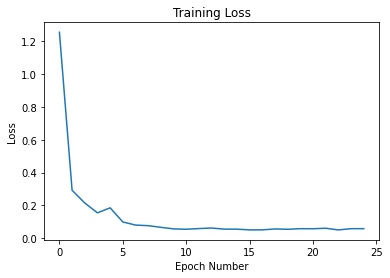

In [26]:
import matplotlib.pyplot as plt

plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

array([[ 85, 149],
       [  2, 388]])